2.1 Gathering dataset


> Dataset(train and test images) SVHN dataset as csv anotations

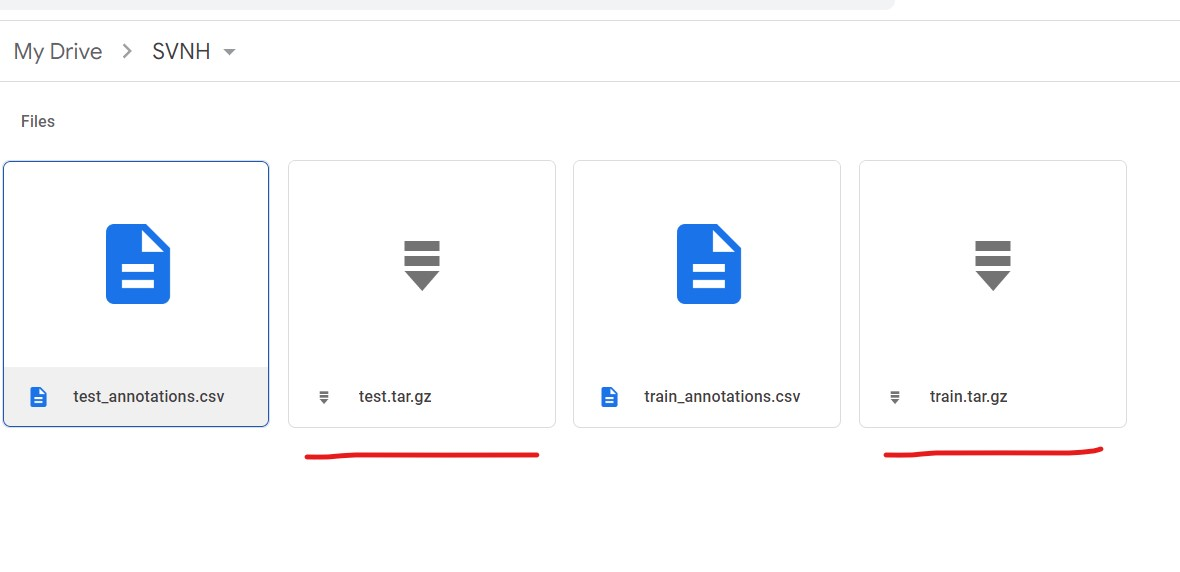







1. Connecting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


2. Importing needed libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import csv
import cv2
import concurrent.futures
from google.colab.patches import cv2_imshow

3.Unpacking dataset

In [ ]:
!tar -xvzf gdrive/MyDrive/SVNH/train.tar.gz
!tar -xvzf gdrive/MyDrive/SVNH/test.tar.gz

Streaming output truncated to the last 5000 lines.
test/2574.png
test/2554.png
test/2550.png
test/2549.png
test/2535.png
test/2528.png
test/2519.png
test/2516.png
test/2510.png
test/2504.png
test/2494.png
test/2491.png
test/2485.png
test/2477.png
test/2470.png
test/2432.png
test/2390.png
test/2385.png
test/2351.png
test/2339.png
test/2320.png
test/2316.png
test/2315.png
test/2296.png
test/2279.png
test/2271.png
test/2258.png
test/2249.png
test/2245.png
test/2229.png
test/2209.png
test/2197.png
test/2192.png
test/2190.png
test/2186.png
test/2178.png
test/2175.png
test/2157.png
test/2154.png
test/2150.png
test/2148.png
test/2128.png
test/2126.png
test/2116.png
test/2103.png
test/2077.png
test/2061.png
test/2047.png
test/2015.png
test/1945.png
test/1939.png
test/1903.png
test/1869.png
test/1859.png
test/1847.png
test/1836.png
test/1826.png
test/1817.png
test/1804.png
test/1796.png
test/1791.png
test/1783.png
test/1773.png
test/1764.png
test/1744.png
test/1718.png
test/1680.png
test/1678.p

4. Reading csv files and converting to numpy array



In [ ]:
with open('gdrive/MyDrive/SVNH/train_annotations.csv') as f:
  reader = csv.reader(f)
  raw = list(reader)
  df_train = np.array(raw,dtype=object)
  header_train = df_train[0]
  # bez naslova (header)
  df_train = df_train[1:]
with open('gdrive/MyDrive/SVNH/test_annotations.csv') as f:
  reader = csv.reader(f)
  raw = list(reader)
  df_test = np.array(raw,dtype=object)
  header_test = df_test[0]
  # bez naslova (header)
  df_test = df_test[1:]

2.2 Preparing dataset

All images that have height less than 80 and width less than 40 pixels, have to throw from dataset.With like this reduced dataset, create a training and test set of numbers cut from images (using bounding box) for each object class (0-9).


Creating directory for image filtration

In [ ]:
%rm -rf train_filtered
%rm -rf test_filtered

!mkdir train_filtered
!mkdir test_filtered
!cp train/* train_filtered
!cp test/* test_filtered

Image filtration

In [ ]:
train_new_path = 'train_filtered/'

print(f'Train has {len(df_train)} images')
df_train_filtered=[]
cnt_removed = 0
for img in df_train:
  path=img[0][6:]
  img_train = cv2.imread(train_new_path+path)
  width,height,_=img_train.shape
  if width > 40 and height > 80:
    df_train_filtered.append(img)
  else:
    os.remove(train_new_path+path)
    cnt_removed += 1

print(f'Removed train images: {cnt_removed}')
print(f'Train now has {len(df_train_filtered)} images')

test_new_path='test_filtered/'

print(f'Test has {len(df_test)} images')
df_test_filtered=[]
cnt_removed = 0
for img in df_test:
  path=img[0][5:]
  img_test = cv2.imread(test_new_path+path)
  width,height,_=img_test.shape
  if width > 40 and height > 80:
    df_test_filtered.append(img)
  else:
    os.remove(test_new_path+path)
    cnt_removed += 1

print(f'Removed test images: {cnt_removed}')
print(f'Test now has {len(df_test_filtered)} images')

Train has 33402 images
Removed train images: 13599
Train now has 19803 images
Test has 13068 images
Removed test images: 3857
Test now has 9211 images


Creating folder for SVHN classification dataset

In [ ]:
%rm -rf svhn_classification_dataset
!mkdir svhn_classification_dataset
!mkdir svhn_classification_dataset/train
!mkdir svhn_classification_dataset/test
for i in range(10):
  os.mkdir('svhn_classification_dataset/train/'+str(i))
  os.mkdir('svhn_classification_dataset/test/'+str(i))

Creating function for cropping images

In [ ]:
def crop_and_copy_SVHN_images(destination_path,start_index:int,end_index:int,list_images):
  for df_image in list_images:
    img_name=df_image[0][start_index:end_index]
    img = cv2.imread(df_image[0])
    shape = img.shape
    for i in range(1,len(df_image[1:])+1):
        if i % 5 == 0:
          x = int(df_image[i-4])
          y = int(df_image[i-3])
          w = int(df_image[i-2])
          h = int(df_image[i-1])
          label = int(df_image[i])
          if x >= 0 and y >= 0:
            crop_img = img[y:y+h, x:x+w]
            # cv2_imshow(crop_img)
            if label == 10:
              label = 0
            cv2.imwrite(destination_path+str(label)+'/'+str(img_name)+'_'+str(label)+'.png',crop_img)
  return True

Here we call the function we created earlier.
Added ThreadPoolExecutor(), split processes (NUM_OF_CORES) into batches of elements, to make cropping images with all its logic more efficient.

In [ ]:
train_destination_path = 'svhn_classification_dataset/train/'
start_index_train = 6
end_index_train = -4

test_destination_path = 'svhn_classification_dataset/test/'
start_index_test = 5
end_index_test = -4

NUM_OF_CORES = 20

batch = int(len(df_train_filtered) / NUM_OF_CORES)
crops_per_core = []

for i in range(NUM_OF_CORES):
    d = df_train_filtered[(i * batch):((i + 1) * batch)]
    crops_per_core.append(d)
d = df_train_filtered[(NUM_OF_CORES * batch):]
crops_per_core.append(d)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(crop_and_copy_SVHN_images,train_destination_path, start_index_train, end_index_train, sublist_crops) for sublist_crops in crops_per_core]

    for f in concurrent.futures.as_completed(results):
        print(f'Process {i}, done: {f.result()}')

print('Train images done.')

batch = int(len(df_test_filtered) / NUM_OF_CORES)
crops_per_core = []

for i in range(NUM_OF_CORES):
    d = df_test_filtered[(i * batch):((i + 1) * batch)]
    crops_per_core.append(d)
d = df_test_filtered[(NUM_OF_CORES * batch):]
crops_per_core.append(d)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(crop_and_copy_SVHN_images,test_destination_path, start_index_test, end_index_test, sublist_crops) for sublist_crops in crops_per_core]

    for f in concurrent.futures.as_completed(results):
        print(f'Process done: {f.result()}')

print('Test images done.')

Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Process 19, done: True
Train images done.
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Process done: True
Test images done.


Checking dataset status

In [ ]:
No_of_files_train = 0
for i in range(10):
  directory_path = 'svhn_classification_dataset/train/'+str(i)
  No_of_files_train += len(os.listdir(directory_path))
print(f'Number of train images: {No_of_files_train}')

No_of_files_test = 0
for i in range(10):
  directory_path = 'svhn_classification_dataset/test/'+str(i)
  No_of_files_test += len(os.listdir(directory_path))
print(f'Number of test images: {No_of_files_test}')

Number of train images: 40921
Number of test images: 17514


In [ ]:
!zip -r svhn_classification_dataset.zip svhn_classification_dataset

Streaming output truncated to the last 5000 lines.
  adding: svhn_classification_dataset/train/4/4010_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/15435_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/5938_4.png (deflated 0%)
  adding: svhn_classification_dataset/train/4/26991_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/7397_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/16792_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/7181_4.png (deflated 1%)
  adding: svhn_classification_dataset/train/4/231_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/24974_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/24354_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/3929_4.png (deflated 0%)
  adding: svhn_classification_dataset/train/4/24329_4.png (stored 0%)
  adding: svhn_classification_dataset/train/4/5301_4.png (stored 0%)
  adding: svhn_classification_dataset/tra

2.3 Training classification NN
Train a classifier for this dataset. The network architecture is arbitrary.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
input_size = (32,32,3)
batch_size = 32

Neural network architecture

In [ ]:
keras.backend.clear_session()

# jednostavnija mreza
# model = keras.Sequential([
#     layers.Rescaling(1./255, input_shape=input_size),
#     layers.Conv2D(8,3,padding='same'),
#     layers.Conv2D(16,3,padding='same'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(10)])


model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=input_size),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),    
    keras.layers.Dense(10)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [ ]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'svhn_classification_dataset/train/',
    labels='inferred',
    label_mode = "int",
    color_mode= 'rgb',
    batch_size = batch_size,
    image_size = (input_size[0],input_size[1]),
    shuffle=True,
    seed=512,
    validation_split=0.2,
    subset='training')

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'svhn_classification_dataset/train/',
    labels='inferred',
    label_mode = "int",
    color_mode= 'rgb',
    batch_size = batch_size,
    image_size = (input_size[0],input_size[1]),
    shuffle=True,
    seed=512,
    validation_split=0.2,
    subset='validation')

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    'svhn_classification_dataset/test/',
    labels='inferred',
    label_mode = "int",
    color_mode= 'rgb',
    batch_size=batch_size,
    image_size = (input_size[0],input_size[1]),
    shuffle=False)

Found 40921 files belonging to 10 classes.
Using 32737 files for training.
Found 40921 files belonging to 10 classes.
Using 8184 files for validation.
Found 17514 files belonging to 10 classes.


Hyperparameters are defined.
  
  I used Adam as an optimizer.
  
  I used LearningRateScheduler for the scheduler.
  
  Loss is SparseCategoricalCrossentropy
  
  The length of training is 20 epochs.

  In addition, EarlyStopping is defined in order to stop the training earlier if necessary. Also ModelCheckpoint which we use to save the best weights from the metrics of the training itself.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-5, amsgrad=True)
lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-5 * 10**(epoch / 10))
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
epochs=20

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
model_checkpoint = ModelCheckpoint(
                   'SVHN_classification_model/best_cnn.h5', 
                   save_best_only=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(ds_train,epochs=epochs,validation_data=ds_validation,callbacks=[lr_schedule,early_stopping,model_checkpoint])

Epoch 1/20
1024/1024 [==============================] - 26s 17ms/step - loss: 2.5139 - accuracy: 0.1320 - val_loss: 2.2644 - val_accuracy: 0.1736 - lr: 1.0000e-05
Epoch 2/20
1024/1024 [==============================] - 15s 15ms/step - loss: 2.2892 - accuracy: 0.1544 - val_loss: 2.2492 - val_accuracy: 0.1819 - lr: 1.2589e-05
Epoch 3/20
1024/1024 [==============================] - 17s 17ms/step - loss: 2.2653 - accuracy: 0.1686 - val_loss: 2.2233 - val_accuracy: 0.1905 - lr: 1.5849e-05
Epoch 4/20
1024/1024 [==============================] - 16s 16ms/step - loss: 2.2335 - accuracy: 0.1835 - val_loss: 2.1549 - val_accuracy: 0.2182 - lr: 1.9953e-05
Epoch 5/20
1024/1024 [==============================] - 17s 16ms/step - loss: 2.1416 - accuracy: 0.2263 - val_loss: 1.9529 - val_accuracy: 0.3294 - lr: 2.5119e-05
Epoch 6/20
1024/1024 [==============================] - 17s 16ms/step - loss: 1.9052 - accuracy: 0.3312 - val_loss: 1.5006 - val_accuracy: 0.5282 - lr: 3.1623e-05
Epoch 7/20
1024/1024 [

In [ ]:
model.save('SVHN_classification_model/', save_format='tf')

We plot the loss and accuracy metrics against the train and validation datasets.

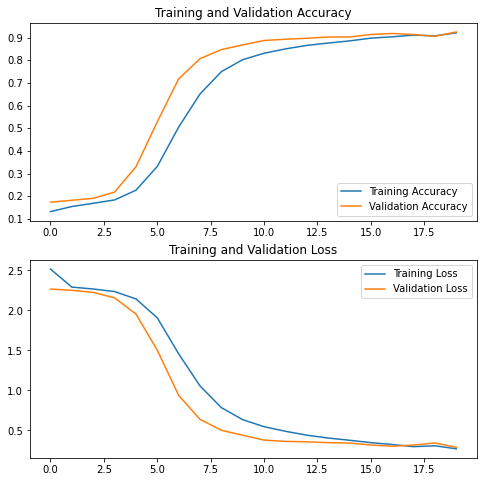

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluation on test dataset

In [ ]:
test_loss,test_accuracy=model.evaluate(ds_test)

548/548 [==============================] - 6s 11ms/step - loss: 0.4263 - accuracy: 0.8787
Test loss: 42.63052940368652 %
Test accuracy: 87.87255883216858 %


2.4. Evaluation of results 

Show the performance of the classifier using the confusion matrix on the test set.

In [ ]:
y_pred = model.predict(ds_test)

548/548 [==============================] - 5s 10ms/step


We unpack the test dataset into a numpy array, where we have a separate array of images, a separate array of labels. We need an array of labels.

In [ ]:
ds_test_unbatched = ds_test.unbatch()
test_images = np.asarray(list(ds_test_unbatched.map(lambda x, y: x)))
test_labels = np.asarray(list(ds_test_unbatched.map(lambda x, y: y)))

LabelBinarizer serves us to transform labels into ground truth labels into 0 or 1, i.e. for that class it will be 1, for the others 0.

In [ ]:
lb = LabelBinarizer()
y_test=lb.fit_transform(test_labels)
print(y_test.shape)

(17514, 10)


We invert the transformation where we extract only a sequence of N values ​​instead of (N,class_number)

In [ ]:
y_pred = lb.inverse_transform(y_pred, lb.classes_)
y_test = lb.inverse_transform(y_test, lb.classes_)

We draw the confusion matrix on the plot, using the seaborn library that helps us draw the heatmap.

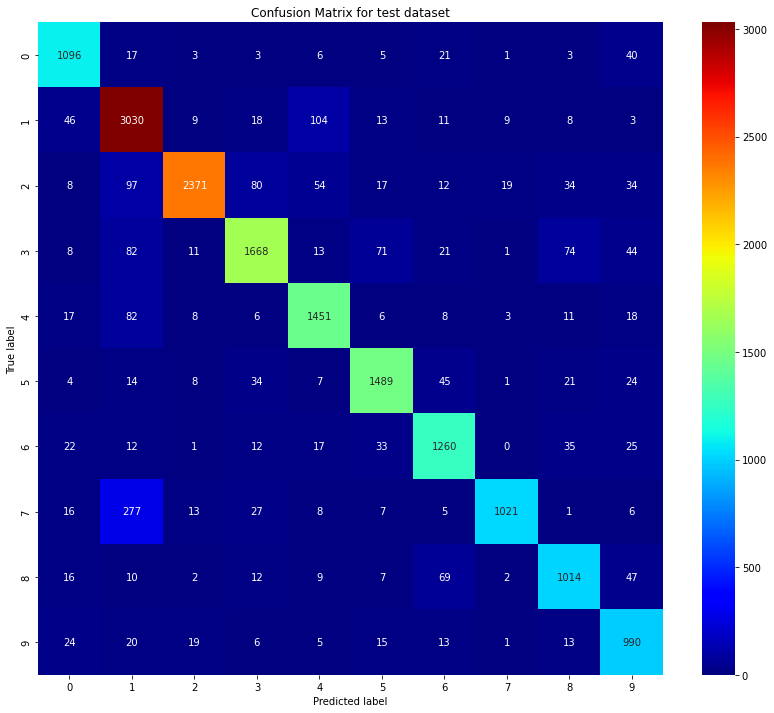

In [ ]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred)

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm, annot=True, cmap='jet', fmt='d', ax=ax)
plt.title('Confusion Matrix for test dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
!zip -r SVHN_classification_model.zip SVHN_classification_model

  adding: SVHN_classification_model/ (stored 0%)
  adding: SVHN_classification_model/assets/ (stored 0%)
  adding: SVHN_classification_model/keras_metadata.pb (deflated 94%)
  adding: SVHN_classification_model/best_cnn.h5 (deflated 10%)
  adding: SVHN_classification_model/variables/ (stored 0%)
  adding: SVHN_classification_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: SVHN_classification_model/variables/variables.index (deflated 73%)
  adding: SVHN_classification_model/saved_model.pb (deflated 89%)


In [ ]:
tflite_path = "svhn_classification_model.tflite"
saved_model_dir = "SVHN_classification_model"


#Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

#Save the model
with open(tflite_path, 'wb') as f:
  f.write(tflite_model)